# DELVE survey progress plots

This notebook generates a set of simple survey status plots.

It was developed using the `ehn37` `conda` environment on the DES cluster at Fermilab.

## Boilerplate

Simple boilerplate with needed `python` imports and notebook configuration.

### Imports

In [1]:
from IPython.core.display import display, HTML
from functools import partial
from collections import OrderedDict
from io import StringIO
from contextlib import redirect_stdout
import os
import sys
import urllib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import astropy
import astropy.coordinates
import astropy.units as u
import psycopg2
import healpy
import requests

These should all be installable with `pip`, and probably `conda` is you prefer.
The versions used in this execution:

In [2]:
print("python", sys.version)
for p in [np, pd, mpl, cartopy, astropy, psycopg2, healpy, requests]:
    print(p.__name__, p.__version__)

python 3.7.3 | packaged by conda-forge | (default, Mar 27 2019, 23:01:00) 
[GCC 7.3.0]
numpy 1.16.3
pandas 0.24.2
matplotlib 3.0.3
cartopy 0.17.0
astropy 3.1.2
psycopg2 2.8.2 (dt dec pq3 ext lo64)
healpy 1.12.9
requests 2.21.0


### `jupyter/ipython` magic.

In [3]:
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

### Configuration

In [4]:
display(HTML("<style>.container { width:90% !important; }</style>"))
mpl.rcParams['figure.figsize'] = (8, 5)
plt.style.use('ggplot')

### Make the notebook reproducible

In [5]:
np.random.seed(6563)

## Configuration

Exposures planned for DELVE.

In [6]:
target_source = 'https://github.com/kadrlica/obztak/blob/delve/obztak/data/delve-target-fields-v10.csv.gz?raw=true'
schedule_source = 'https://github.com/delve-survey/observing/raw/master/data/schedule_through_2019B.txt'

## Constants

In [7]:
EARTH_DIAMETER = 2*6378140
ORTHO = ccrs.Orthographic(central_longitude=0, central_latitude=-89.99)
LAEA = ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=-89.99)
STEREO = ccrs.SouthPolarStereo()
PC = ccrs.PlateCarree()
SITE = astropy.coordinates.EarthLocation.of_site('Cerro Tololo')
MJD_EPOCH = pd.to_datetime("1858-11-17T00:00:00+00:00", infer_datetime_format=True)
DECAM_AREA = 2.78 ;# Footprint of DECam good pixels in square degrees

## Get planned DELVE exposures

Actually read the field list from `obztak`:

In [8]:
all_target_fields = pd.read_csv(target_source, compression='gzip', comment="#")
real_fields_query = "(PRIORITY>0 or PROGRAM=='delve-deep') and not (PROGRAM=='delve-wide' and TILING==4)"
target_fields = all_target_fields.query(real_fields_query)

## Get completed DELVE exposures

There are a few ways of getting the exposure data from the SISPI database. They all ultimately get data from the following query:

In [9]:
completed_query = """
SELECT id, date, flavor, ra, declination AS decl, filter AS band, exptime,
       qc_fwhm, qc_sky, qc_cloud, qc_teff, qc_eps,
       ha, zd, az, moonangl, lst, propid,
       program, object, seqid,
       hex_id, tiling_id
FROM exposure.exposure
WHERE NOT aborted
  AND ( qc_teff > 0.3 OR (propid IN ('2019A-0305')) OR (object LIKE '%DELVE%') )
  AND exptime > 30
  AND flavor = 'object'
ORDER BY id
"""

The `sispidb` method is most direct, but requires the password for the database in your `~/.pgpass`. This database can be queried through the "telemety viewer" web interface without a password. I started trying to get this notebook to make the query through this interface, but it isn't complete (or working at all, really) yet. In the mean time you can execute the query yourself [here](http://des-ops.fnal.gov:8080/TV/app/Q/index), save the result as a `csv`, and load it by setting `completed_origin` to the file name.

In [10]:
completed_origin = 'sispidb'
#completed_origin = '/data/des70.a/data/neilsen/delve_strategy/data/collected/sispi_delve_exposures.csv'
#completed_origin = 'telemetry_viewer'

In [11]:
if completed_origin == 'sispidb':
    print("Querying the SISPI database")
    sispidb_connect = partial(psycopg2.connect, 
                              database='decam_prd',
                              user='decam_reader',
                              host='des61.fnal.gov',
                              port=5443)
    # Get the password from ~/.pgpass
    with sispidb_connect() as conn:
        decam_completed = pd.read_sql(completed_query, conn)
elif completed_origin=='telemetry_viewer':
    print("Querying the telemetry viewer")
    tv_url = 'http://des-ops.fnal.gov:8080/TV/app/Q/index'
    post_fields = {'namespace': 'exposure',
                   'output': 'csv',
                   'sql': completed_query}
    result = requests.post(tv_url, post_fields)
    raise NotImplementedError
else:
    print(f"Reading from {completed_origin}")
    decam_completed = pd.read_csv(completed_origin, parse_dates=['date']).query('flavor=="object"')

Querying the SISPI database


In [12]:
decam_completed['mjd'] = (decam_completed['date'] - MJD_EPOCH).dt.total_seconds()/(24*60*60)
decam_completed['good'] = decam_completed.qc_teff > 0.3

Look just at exposure taked as part of DELVE, and extract DELVE hex and tiling ids

In [13]:
completed = decam_completed.query('propid=="2019A-0305"').copy()
completed['hex'] = completed['object'].str.extract(r'DELVE field: (\d+)-..-.').astype(float)
completed['tiling'] = completed['object'].str.extract(r'DELVE field: \d+-(\d\d)-.').astype(float)

## Map planned exposures

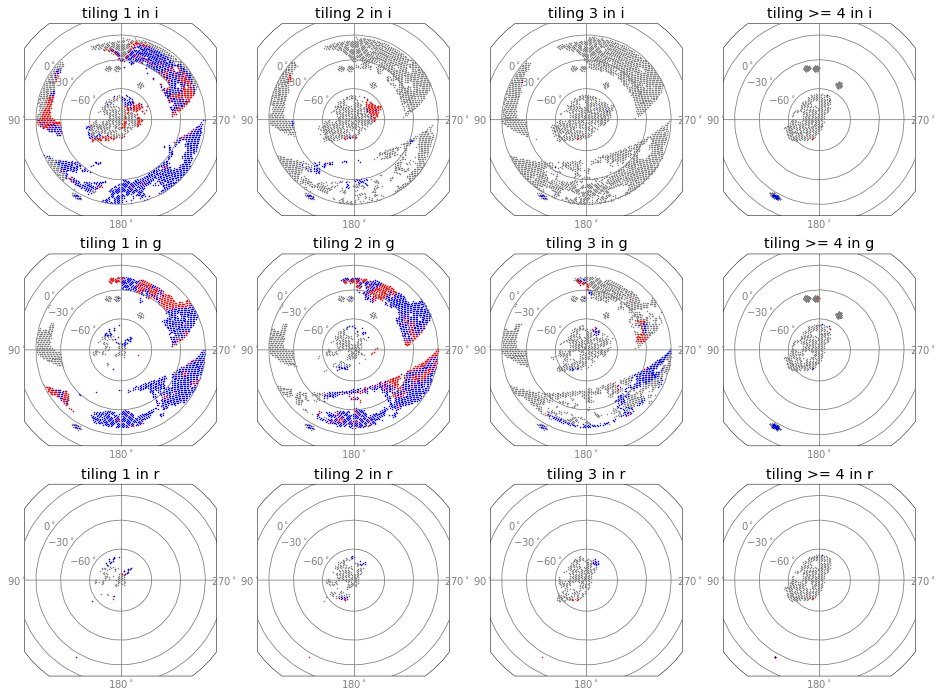

In [14]:
bands = target_fields['FILTER'].unique()
subplot_size = 4
fig = plt.figure(figsize=(4*subplot_size, len(bands)*subplot_size))

for band_idx, band in enumerate(bands):
    for tiling in np.arange(1,5):
        axes = fig.add_subplot(len(bands), 4, tiling + 4*band_idx, projection=LAEA)
        
        if tiling <= 3:
            these_fields = target_fields.query(f'FILTER=="{band}" and TILING=={tiling}')
            these_completed = completed.query(f'band=="{band}" and tiling=={tiling} and good')
            these_bad = completed.query(f'band=="{band}" and tiling=={tiling} and not good')
            axes.set_title(f'tiling {tiling} in {band}')
        else:
            these_fields = target_fields.query(f'FILTER=="{band}" and TILING>={tiling}')
            these_completed = completed.query(f'band=="{band}" and tiling>={tiling} and good')
            these_bad = completed.query(f'band=="{band}" and tiling>={tiling} and not good')
            axes.set_title(f'tiling >= {tiling} in {band}')
            
        axes.scatter(these_fields.RA, these_fields.DEC, s=1, c='gray', transform=PC)
        axes.scatter(these_bad.ra, these_bad.decl, c='red', s=1, transform=PC)
        axes.scatter(these_completed.ra, these_completed.decl, c='blue', s=1, transform=PC)
        
        axes.set_xlim(-0.8*EARTH_DIAMETER, 0.8*EARTH_DIAMETER)
        axes.set_ylim(-0.8*EARTH_DIAMETER, 0.8*EARTH_DIAMETER)

        axes.set_xlim(reversed(axes.get_xlim()))
        gl = axes.gridlines(crs=PC, draw_labels=False, color='gray')

        meridian_ra = np.arange(0, 360+90, 90)
        meridian_decl = {ra: 30 for ra in meridian_ra}
        meridian_label = {ra: "$%d^\circ$" % ra for ra in meridian_ra}
        meridian_params = {ra: {'horizontalalignment': 'center', 'verticalalignment': 'center', 'color': 'gray', 'weight': 'bold', 'transform': PC} for ra in meridian_ra}
        gl.xlocator = mpl.ticker.FixedLocator(meridian_ra)
        gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
        meridian_labels = [axes.text(ra, meridian_decl[ra], meridian_label[ra], **meridian_params[ra]) for ra in meridian_ra if 1 < ra < 350]

        parallel_decl = np.arange(-90, 60, 30)
        parallel_ra = {decl: 50 for decl in parallel_decl}
        parallel_label = {decl: "$%d^\circ$" % decl for decl in parallel_decl}
        parallel_params = {ra: {'horizontalalignment': 'right', 'verticalalignment': 'center', 'color': 'gray', 'weight': 'bold', 'transform': PC} for ra in parallel_ra}

        gl.ylocator = mpl.ticker.FixedLocator(parallel_decl)
        gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER
        parallel_labels = [axes.text(parallel_ra[decl], decl, parallel_label[decl], **parallel_params[decl]) for decl in parallel_decl if 10 > decl > -88]


## Comparison to schedule

In [15]:
schedule = pd.read_csv(schedule_source, parse_dates=[0], sep="\t").query('propid == "0305"')

In [16]:
def twilight_times(night_mjds, which_direction='down', which_night='nearest', alt=-14.0, location=SITE, body='sun', tolerance=1e-8, max_iter=5):
    """Find morning or evening twilight using Newton's iterative method
    
    This only works at central latitudes!
    
    Args:
        night_mjds - numpy array of MJDs of nights (integers)
        which_twilight -- 'evening' or 'morning'
        alt -- altitude of twilight, in degrees
        location -- astropy.coordinates.EarthLocation for site
        tolerance -- tolerance for twilight altitude, in degrees
        max_iter -- maximum iterations in Newton's method
        
    Returns:
        numpy array of mjds
    
    """
    event_direction = 1 if which_direction=='down' else -1
    
    night_wraps = {'previous': 0.0, 'nearest': 180.0, 'next': 360.0}
    night_wrap = night_wraps[which_night]
 
    mjds = night_mjds

    # Get close (to of order body motion per day)
    times = astropy.time.Time(mjds, scale='utc', format='mjd', location=location)
    lsts = times.sidereal_time('apparent', longitude=location.lon)
    crds = astropy.coordinates.get_body(body, times, location=location)
    hour_angles = (lsts - crds.ra)
    event_hour_angles = event_direction * np.arccos(
        (np.sin(np.radians(alt)) - np.sin(crds.dec)*np.sin(location.lat))
        /(np.cos(crds.dec)*np.cos(location.lat)) )
    event_hour_angles = astropy.coordinates.Angle(event_hour_angles, unit=u.radian)
    ha_diff = (event_hour_angles - hour_angles).wrap_at(night_wrap*u.deg)
    mjds = mjds + ha_diff.radian*(0.9972696/(2*np.pi))
    
    # Refine using Newton's method
    for iter_idx in range(max_iter):
        times = astropy.time.Time(mjds, scale='utc', format='mjd', location=location)
        crds = astropy.coordinates.get_body(body, times, location=location)
        current_alt = crds.transform_to(astropy.coordinates.AltAz(obstime=times, location=location)).alt
        finished = np.max(np.abs(current_alt.deg - alt)) < tolerance
        if finished:
            break
            
        current_sinalt = np.sin(current_alt.rad)
        target_sinalt = np.sin(np.radians(alt))

        ha = times.sidereal_time('apparent') - crds.ra
        # Derivative of the standard formula for sin(alt) in terms of decl, latitude, and HA
        dsinalt_dlst = (-1*np.cos(crds.dec)*np.cos(location.lat)*np.sin(ha)).value
        dsinalt_dmjd = dsinalt_dlst * (2*np.pi/0.9972696)
        mjds = mjds - (current_sinalt - target_sinalt)/dsinalt_dmjd
    
    if np.max(np.abs(mjds - night_mjds)) > 1:
        warn("On some nights, found twilight more than a day away from the night mjd")
    
    if not finished:
        warn("twilight_times did not converge")
    
    return mjds

In [17]:
schedule['evening'] = twilight_times(schedule.mjd, 'down')
schedule['morning'] = twilight_times(schedule.mjd, 'up')
schedule['midnight'] = 0.5*(schedule.morning+schedule.evening)
schedule['duration'] = 0.5*(schedule.morning-schedule.evening)

In [18]:
schedule.describe().T

,count,mean,std,min,25%,50%,75%,max
mjd,256.0,59049.289062,312.310634,58521.000000,58803.750000,59051.500000,59288.000000,59583.000000
propid,256.0,305.000000,0.000000,305.000000,305.000000,305.000000,305.000000,305.000000
evening,256.0,59049.286218,312.315766,58521.030942,58803.768214,59051.464429,59288.001723,59583.042095
morning,256.0,59049.687810,312.303942,58521.382289,58804.103854,59051.937831,59288.404389,59583.358075
midnight,256.0,59049.487014,312.309853,58521.206615,58803.936034,59051.701130,59288.203056,59583.200085
duration,256.0,0.200796,0.029779,0.156057,0.175528,0.200992,0.229022,0.241600


In [19]:
start_mjd = min(schedule.mjd.min(), completed.mjd.min())-1
end_mjd = max(schedule.mjd.max(), completed.mjd.max())+2
mjds = np.arange(start_mjd, end_mjd, 1)
progress = pd.DataFrame({'mjd': mjds, 'exptime': 0, 'duration': 0})
progress.set_index('mjd', inplace=True)
progress['duration'] = schedule.groupby('mjd').duration.sum()
progress.fillna(0, inplace=True)
progress['cum_sched'] = progress.duration.cumsum()

completed['night_mjd'] = np.floor(completed.mjd - 0.9)
completed['obstime'] = completed.exptime + 30
progress['all_obstime'] = completed.groupby('night_mjd').agg({'obstime': 'sum'})
progress['good_obstime'] = completed.query('qc_teff>0.2').groupby('night_mjd').agg({'obstime': 'sum'})
progress.fillna(0, inplace=True)
progress['cum_all_obstime'] = progress.all_obstime.cumsum()/(24*60*60)
progress['cum_good_obstime'] = progress.good_obstime.cumsum()/(24*60*60)

progress.reset_index(inplace=True)
progress['date'] = MJD_EPOCH + progress.mjd.apply(lambda d: pd.Timedelta(d, unit='D'))

progress.describe().T

,count,mean,std,min,25%,50%,75%,max
mjd,1065.0,59052.000000,307.583322,58520.0,58786.000000,59052.000000,59318.000000,59584.000000
exptime,1065.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
duration,1065.0,0.048266,0.106662,0.0,0.000000,0.000000,0.000000,0.481538
cum_sched,1065.0,26.298957,14.730177,0.0,13.119736,26.578508,41.002239,51.403775
all_obstime,1065.0,773.045070,4664.018990,0.0,0.000000,0.000000,0.000000,41460.000000
good_obstime,1065.0,651.842254,4065.460951,0.0,0.000000,0.000000,0.000000,40680.000000
cum_all_obstime,1065.0,8.668859,2.130375,0.0,9.528854,9.528854,9.528854,9.528854
cum_good_obstime,1065.0,7.349177,1.714352,0.0,8.034861,8.034861,8.034861,8.034861


/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


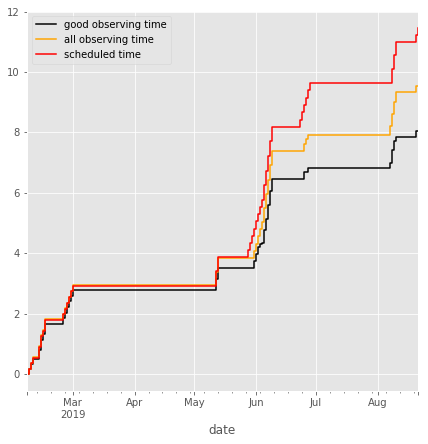

In [20]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
past = progress[progress['date'] < pd.Timestamp.now(tz=progress['date'][0].tz)]
past.plot('date', 'cum_good_obstime', drawstyle="steps-post", c='k', ax=ax, label='good observing time')
past.plot('date', 'cum_all_obstime', drawstyle="steps-post", c='orange', ax=ax, label='all observing time')
past.plot('date', 'cum_sched', c='r', drawstyle="steps-post", ax=ax, label='scheduled time')

## Overall depth map

Plot the total `qc_teff * exptime` by healpixel, giving a rough idea of our coverage. For the DELVE wide target of 3 by 90 second tilings with `qc_teff>0.3`, this would be `3*90*0.3=81` seconds.

In [21]:
def teff_map(exposures, nside=32, **kwargs):
    exposures = exposures.copy()
    exposures['hpix'] = healpy.pixelfunc.ang2pix(nside, 
                                                 exposures['ra'], 
                                                 exposures['decl'],
                                                 lonlat=True)
    exposures['totteff'] = exposures['exptime']*exposures['qc_teff']
    depth_df = exposures.groupby('hpix').totteff.sum().reset_index().set_index('hpix', drop=False)
    npix = healpy.nside2npix(nside)
    depth = np.zeros(npix)
    depth[depth_df.hpix] = depth_df.totteff * DECAM_AREA / healpy.nside2pixarea(nside, degrees=True)
    healpy.azeqview(np.ma.masked_where(depth==0, depth),
                rot=(0, -90, 0), reso=18, lamb=True, **kwargs)
    healpy.visufunc.graticule()


In [22]:
def multi_teff_map(completed, nside=32, bands=['u','g','r','i','z','Y','VR'], size=4, ncols=3, **kwargs):
    nbands = len(bands)
    nrows = int(np.ceil(nbands/ncols))
    fig, axes2d = plt.subplots(nrows, ncols, figsize=(ncols*size, nrows*size*1.2))
    axes = axes2d.flatten()
    for ax, band in zip(axes[:nbands], bands):
        plt.sca(ax)
        exposures = completed.query(f'qc_teff>0.3 and band=="{band}"').copy()
        teff_map(exposures, hold=True, title=f"Total t_eff, {band} band", **kwargs)
    
    for ax in axes[nbands:]:
        ax.set_visible(False)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/healpy/projector.py:1081: RuntimeWarning: divide by zero encountered in true_divide
  kprime = np.sqrt(2.0 / (1.0 + np.cos(lat) * np.cos(phi)))
/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/healpy/projector.py:1086: RuntimeWarning: invalid value encountered in multiply
  y = kprime * np.sin(lat)
/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/healpy/projector.py:1096: RuntimeWarning: invalid value encountered in greater
  mask = np.asarray(x) ** 2 + np.asarray(y) ** 2 > r2max
/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/healpy/projaxes.py:416: RuntimeWarning: invalid value encountered in greater
  w = np.where(d2 > threshold)[0]


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The inter

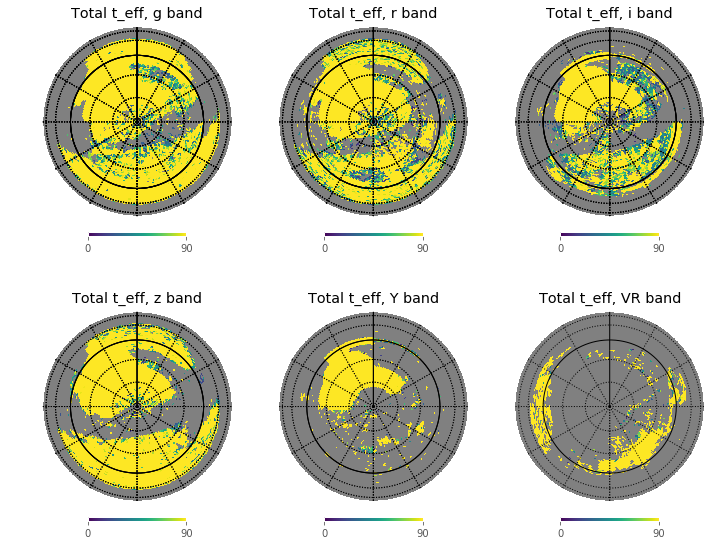

In [23]:
multi_teff_map(decam_completed, bands=['g','r','i','z','Y','VR'], min=0, max=90, cmap='viridis')